In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tensorflow-gpu==2.2.0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
tf.test.gpu_device_name()

     |████████████████████████████████| 516.2MB 32kB/s 


'/device:GPU:0'

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
########################################
np.random.seed(27)
tf.random.set_seed(27)
tf.compat.v1.reset_default_graph()
BATCH_SIZE = 200
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0.001, 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
def plot_metrics(history):
  metrics =  ['accuracy', 'precision', 'recall','F1_score']
  plt.figure(figsize=(10,8))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color="b", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="r", linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0.,1])
    plt.legend(loc="best")
def evaluate(predict):
    print("Test accuracy = ",sum(predict[0] == predict[1])/len(predict[0]))
    print("mu =" , np.mean(predict[0]-predict[1]))
    print("sigma = ",np.std(predict[0]-predict[1]))
    print("RMSE = ",np.sqrt(np.mean((predict[0]-predict[1])**2)))
    print("1st order poly fit:", np.polyfit(predict[0],predict[1],deg=1))
def micro_scores(cm):
    precision = np.zeros((len(cm)))
    recall = np.zeros((len(cm)))
    F1score = np.zeros((len(cm)))
    for i in range(len(cm)):
        precision[i] = cm[i,i]/sum(cm[:,i])
        recall[i] = cm[i,i]/sum(cm[i,:])
        F1score[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
    print("print percisions; recalls; F1 scores")
    print(precision)
    print(recall)
    print(F1score)
    return precision, recall, F1score

In [ ]:
# load data  
# split train and test
from sklearn.model_selection import train_test_split
obsid_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_obsid.npy')
spectra_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_spectra.npy')
obsid_subclasslabel = np.genfromtxt('/content/drive/My Drive/CNN_spectra_data/dr5_SNR100_obsid_subclasslabel.csv'\
                                 ,delimiter=",",dtype=int)
unique_subclasses, counts = np.unique(obsid_subclasslabel[:,1], return_counts = True)
print("classes and counts : ",dict(zip(unique_subclasses,counts)))
num_subclasses = max(unique_subclasses)-min(unique_subclasses)+1
print("number of diff classes = ", num_subclasses)
num_spectra = len(obsid_subclasslabel)
spectra_NN = np.zeros((num_spectra,len(spectra_all[0])))
for i in range(num_spectra):
    index_of_spectra = np.where(obsid_all == obsid_subclasslabel[i][0])
    spectra_NN[i] = spectra_all[index_of_spectra]
spectra_train, spectra_val_test, label_train, label_val_test = train_test_split(spectra_NN,
                                                    obsid_subclasslabel[:,1] - min(unique_subclasses),
                                                    test_size = 0.2,
                                                    random_state = 27)


x_train = np.expand_dims(spectra_train,axis=2)
x_val_test = np.expand_dims(spectra_val_test,axis=2)
y_train = tf.one_hot(label_train, depth = 38, axis = 1 ,dtype=tf.int8)
y_val_test = tf.one_hot(label_val_test, depth = 38, axis = 1 ,dtype=tf.int8)

val_amount = int(len(x_val_test)/4)
x_val = x_val_test[:val_amount]
y_val = y_val_test[:val_amount]

x_test = x_val_test[val_amount:]
y_test = y_val_test[val_amount:]
label_test = label_val_test[val_amount:]
print(len(y_train))
print(len(y_val))
print(len(y_test))

classes and counts :  {16: 1035, 19: 221, 20: 200, 21: 4538, 22: 3112, 23: 295, 25: 1192, 26: 2117, 27: 2902, 28: 210, 29: 304, 30: 7273, 32: 969, 33: 1180, 34: 860, 35: 6454, 36: 2092, 37: 2327, 38: 628, 39: 1440, 40: 1168, 41: 448, 42: 1704, 43: 1395, 44: 111, 45: 280, 46: 116, 47: 260, 48: 90, 49: 13, 50: 3, 51: 55, 53: 5}
number of diff classes =  38
35997
2250
6750


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 4096, 1)           4         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 8192)              33562624  
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

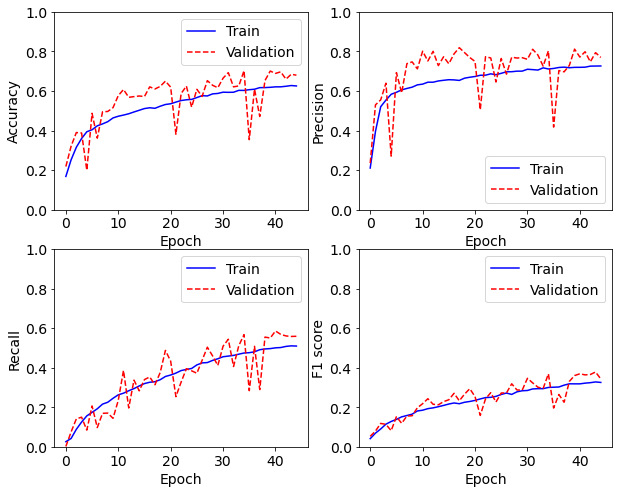

In [ ]:
"""
MLP
"""
model_MLP = tf.keras.Sequential()
model_MLP.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(len(spectra_NN[0]),1)))
model_MLP.add(tf.keras.layers.Flatten())
model_MLP.add(tf.keras.layers.Dense(4096*2,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(2048,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(512,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(num_subclasses,activation="softmax")) #2 represent output layer neurons 
model_MLP.summary()
model_MLP.compile(loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall',\
                       tfa.metrics.F1Score(num_classes= 38,average="macro",name='F1_score',)])
MLP_init_weights = model_MLP.get_weights()

model_MLP.set_weights(MLP_init_weights)
MLP_sub_hs = model_MLP.fit(x_train, y_train,
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val))
print(MLP_sub_hs.history.keys())

plot_metrics(MLP_sub_hs)

prediction_MLP = model_MLP.predict(x_test)
predicted_label_MLP = np.zeros((len(label_test)))
for i in range(len(prediction_MLP)):
    predicted_label_MLP[i] = np.argmax(prediction_MLP[i])
cm_MLP = tf.math.confusion_matrix(label_test,predicted_label_MLP)

np.save('/content/drive/My Drive/CNN_prediction/sub_MLP_predict.npy', np.vstack([label_test,predicted_label_MLP]))

In [ ]:
 evaluate(np.vstack([label_test,predicted_label_smote]))

Test accuracy =  0.6654814814814815
mu = 0.044
sigma =  1.924960105406709
RMSE =  1.9254629073049958
1st order poly fit: [0.97176218 0.38431536]


In [ ]:
"""
CNN model
"""

model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(4096,1)))
model_CNN.add(tf.keras.layers.Conv1D(filters=16,kernel_size=8,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Conv1D(filters=32,kernel_size=4,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Conv1D(filters=64,kernel_size=4,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.Flatten())
#model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
#model_CNN.add(tf.keras.layers.Dense(2048,activation="relu"))
#model_CNN.add(tf.keras.layers.Dropout(0.2))
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Dense(1024,activation="relu"))
model_CNN.add(tf.keras.layers.Dropout(0.2))
model_CNN.add(tf.keras.layers.Dense(38,activation="softmax")) #2 represent output layer neurons 
model_CNN.summary()
model_CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall',\
                       tfa.metrics.F1Score(num_classes= 38,average="macro",name='F1_score',)])
initial_weights = model_CNN.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 4096, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 4089, 16)          144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1022, 16)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1022, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1019, 32)          2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 254, 32)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 254, 32)          

Epoch 1/100
180/180 [==============================] - 4s 21ms/step - loss: 2.6393 - accuracy: 0.3789 - precision: 0.4588 - recall: 0.2933 - F1_score: 0.1556 - val_loss: 4.4176 - val_accuracy: 0.0458 - val_precision: 0.1864 - val_recall: 0.0049 - val_F1_score: 0.0147
Epoch 2/100
180/180 [==============================] - 3s 18ms/step - loss: 1.4851 - accuracy: 0.5240 - precision: 0.6027 - recall: 0.4349 - F1_score: 0.2445 - val_loss: 3.9147 - val_accuracy: 0.1009 - val_precision: 0.0796 - val_recall: 0.0182 - val_F1_score: 0.0335
Epoch 3/100
180/180 [==============================] - 3s 18ms/step - loss: 1.1873 - accuracy: 0.5844 - precision: 0.6624 - recall: 0.4895 - F1_score: 0.2900 - val_loss: 1.9366 - val_accuracy: 0.3667 - val_precision: 0.4325 - val_recall: 0.2009 - val_F1_score: 0.1377
Epoch 4/100
180/180 [==============================] - 3s 18ms/step - loss: 1.0197 - accuracy: 0.6211 - precision: 0.7003 - recall: 0.5258 - F1_score: 0.3272 - val_loss: 1.2241 - val_accuracy: 0.5

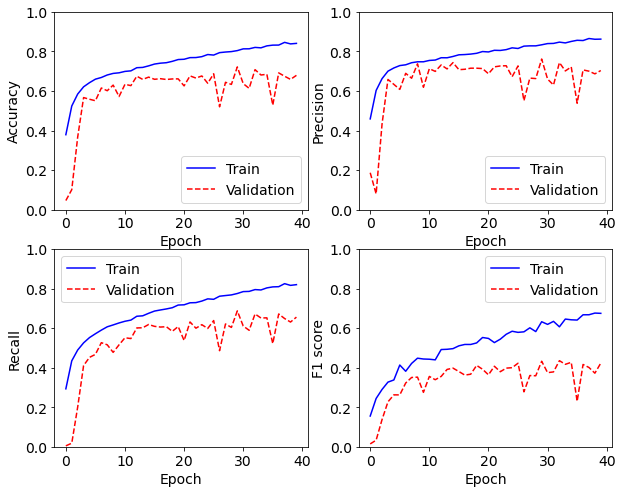

In [ ]:
"""
Basic CNN
"""

CNN_sub_hs = model_CNN.fit(x_train, y_train,
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val))
#test_accuracy = model_CNN.evaluate(x_test, y_test, verbose=0)
#print('\n', 'Test_Accuracy = ', test_accuracy[1])
#model_CNN.save('CNN_LAMOST.h5')
plot_metrics(CNN_sub_hs)

prediction_CNN = model_CNN.predict(x_test)
predicted_label_CNN = np.zeros((len(label_test)))
for i in range(len(prediction_CNN)):
    predicted_label_CNN[i] = np.argmax(prediction_CNN[i])
cm_CNN = tf.math.confusion_matrix(label_test,predicted_label_CNN)
#np.save('/content/drive/My Drive/CNN_cm/sub_CNN_basic_cm.npy', cm_CNN)
np.save('/content/drive/My Drive/CNN_prediction/sub_CNN_basic_predict.npy', np.vstack([label_test,predicted_label_CNN]))

Epoch 1/100
180/180 [==============================] - 3s 18ms/step - loss: 37.8007 - accuracy: 0.2289 - precision: 0.1906 - recall: 0.0591 - F1_score: 0.0983 - val_loss: 3.5406 - val_accuracy: 0.0373 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_F1_score: 0.0067
Epoch 2/100
180/180 [==============================] - 3s 18ms/step - loss: 8.8132 - accuracy: 0.4440 - precision: 0.6316 - recall: 0.1600 - F1_score: 0.2094 - val_loss: 4.3693 - val_accuracy: 0.0173 - val_precision: 0.5000 - val_recall: 0.0013 - val_F1_score: 0.0110
Epoch 3/100
180/180 [==============================] - 3s 18ms/step - loss: 7.4745 - accuracy: 0.5087 - precision: 0.6812 - recall: 0.2507 - F1_score: 0.2577 - val_loss: 2.9584 - val_accuracy: 0.0827 - val_precision: 0.1078 - val_recall: 0.0209 - val_F1_score: 0.0436
Epoch 4/100
180/180 [==============================] - 3s 19ms/step - loss: 6.6859 - accuracy: 0.5475 - precision: 0.7012 - recall: 0.3244 - F1_score: 0.2884 - val_loss: 1.6120 - val_accu

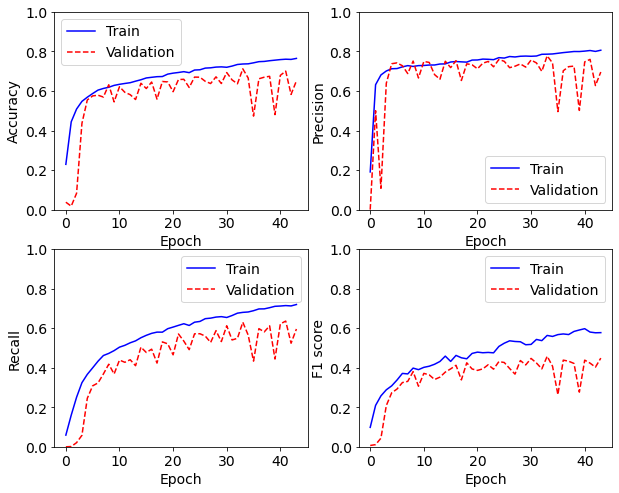

In [ ]:


"""
Class weightening
"""
unique_labels, counts_label_train = np.unique(label_train,return_counts= True)
class_weights_num = np.sqrt(1/counts_label_train * len(label_train))
class_weights_dict = dict(zip(unique_labels,class_weights_num))
fake_classes = np.arange(num_subclasses)
fake_weights_num = np.zeros((38))
for i in range(38):
    try:
        fake_weights_num[i] = class_weights_dict[i]
    except:
        pass
class_weights = dict(zip(fake_classes,fake_weights_num))

model_CNN.set_weights(initial_weights)
CW_sub_hs = model_CNN.fit(x_train, y_train,
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val),
          class_weight = class_weights)
plot_metrics(CW_sub_hs)

prediction_CW = model_CNN.predict(x_test)
predicted_label_CW = np.zeros((len(label_test)))
for i in range(len(prediction_CW)):
    predicted_label_CW[i] = np.argmax(prediction_CW[i])
cm_CW = tf.math.confusion_matrix(label_test,predicted_label_CW)
#np.save('/content/drive/My Drive/CNN_cm/sub_CNN_cw_cm.npy', cm_CW)
np.save('/content/drive/My Drive/CNN_prediction/sub_CNN_cw_predict.npy', np.vstack([label_test,predicted_label_CW]))

classify data into list is done
processing class : 0
processing class : 3
processing class : 4
processing class : 5
processing class : 6
processing class : 7
processing class : 9
processing class : 10
processing class : 11
processing class : 12
processing class : 13
processing class : 14
processing class : 16
processing class : 17
processing class : 18
processing class : 19
processing class : 20
processing class : 21
processing class : 22
processing class : 23
processing class : 24
processing class : 25
processing class : 26
processing class : 27
processing class : 28
processing class : 29
processing class : 30
processing class : 31
processing class : 32
processing class : 33
processing class : 34
processing class : 35
processing class : 37
Epoch 1/100
83/83 [==============================] - 2s 23ms/step - loss: 10.6372 - accuracy: 0.1411 - precision: 0.1578 - recall: 0.1199 - F1_score: 0.1223 - val_loss: 6.0118 - val_accuracy: 0.0089 - val_precision: 0.0172 - val_recall: 0.0044 - val

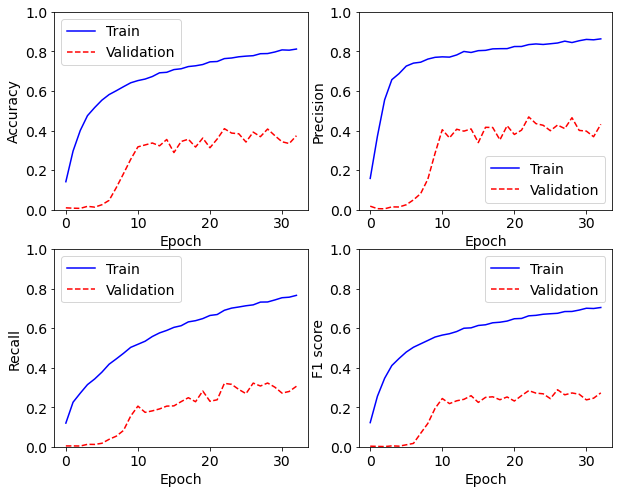

In [ ]:
"""
Oversampling 
"""
target_num = 500
x_classed = [ [] for _ in range(num_subclasses)]
y_classed = [ [] for _ in range(num_subclasses)]
for i in range(len(x_train)):
    x_classed[label_train[i]].append(x_train[i])
    y_classed[label_train[i]].append(y_train[i])
print("classify data into list is done")

resampled_x = np.empty((0,4096,1))
resampled_y = np.empty((0,num_subclasses))
for j in range(len(x_classed)):
    if len(x_classed[j]) != 0:
        choices = np.random.choice(len(x_classed[j]),target_num)
        print("processing class :" ,j)
        for k in range(len(choices)):
            one_train_x = x_classed[j][choices[k]]
            one_train_y = y_classed[j][choices[k]]
            one_train_x = np.expand_dims(one_train_x,axis=0)
            one_train_y = np.expand_dims(one_train_y,axis=0)
            resampled_x = np.concatenate([resampled_x,one_train_x],axis = 0)
            resampled_y = np.concatenate([resampled_y,one_train_y],axis = 0)


order = np.arange(len(resampled_y))
np.random.shuffle(order)
resampled_x= resampled_x[order]
resampled_y = resampled_y[order]

model_CNN.set_weights(initial_weights)
re_sub_hs = model_CNN.fit(resampled_x, resampled_y,
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val))
plot_metrics(re_sub_hs)

prediction_re = model_CNN.predict(x_test)
predicted_label_re = np.zeros((len(label_test)))
for i in range(len(prediction_re)):
    predicted_label_re[i] = np.argmax(prediction_re[i])
cm_re= tf.math.confusion_matrix(label_test,predicted_label_re)
#np.save('/content/drive/My Drive/CNN_cm/sub_CNN_oversample_cm.npy', cm_re)
np.save('/content/drive/My Drive/CNN_prediction/sub_CNN_oversample_predict.npy', np.vstack([label_test,predicted_label_re]))

data processed
Epoch 1/50
966/966 [==============================] - 17s 18ms/step - loss: 2.0825 - accuracy: 0.5087 - precision: 0.6480 - recall: 0.3618 - F1_score: 0.4402 - val_loss: 1.6912 - val_accuracy: 0.3956 - val_precision: 0.4809 - val_recall: 0.2849 - val_F1_score: 0.2770
Epoch 2/50
966/966 [==============================] - 17s 18ms/step - loss: 0.7769 - accuracy: 0.7079 - precision: 0.7886 - recall: 0.6148 - F1_score: 0.6127 - val_loss: 1.8728 - val_accuracy: 0.4342 - val_precision: 0.5252 - val_recall: 0.3524 - val_F1_score: 0.2554
Epoch 3/50
966/966 [==============================] - 17s 17ms/step - loss: 0.6322 - accuracy: 0.7618 - precision: 0.8179 - recall: 0.7025 - F1_score: 0.6599 - val_loss: 1.3642 - val_accuracy: 0.5729 - val_precision: 0.6255 - val_recall: 0.5062 - val_F1_score: 0.4082
Epoch 4/50
966/966 [==============================] - 17s 17ms/step - loss: 0.5370 - accuracy: 0.7983 - precision: 0.8412 - recall: 0.7569 - F1_score: 0.6921 - val_loss: 1.5951 - va

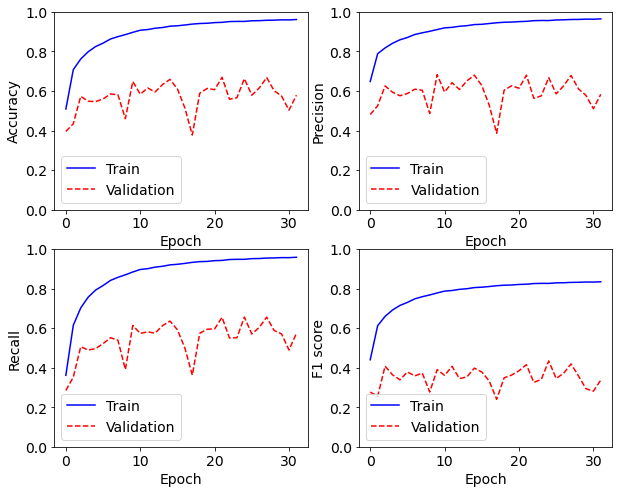

In [ ]:
"""
Smote sampling
"""


spectra_smote = np.load("/content/drive/My Drive/CNN_spectra_data/subclass_spectra_smote.npy")
label_smote = np.load("/content/drive/My Drive/CNN_spectra_data/subclass_label_smote.npy")
x_smote = np.expand_dims(spectra_smote, axis=2)
y_smote = tf.one_hot(label_smote, depth = 38, axis = 1 ,dtype=tf.int8)
print("data processed")
model_CNN.set_weights(initial_weights)
re_hs = model_CNN.fit(x_smote, y_smote,
          batch_size = BATCH_SIZE,
          epochs=50,
          callbacks = [early_stop],
          validation_data=(x_val, y_val))

tf.saved_model.save( model_CNN, "/content/drive/My Drive/CNN_models/sub_class_model")

plot_metrics(re_hs)

prediction_smote = model_CNN.predict(x_test)
predicted_label_smote = np.zeros((len(label_test)))
for i in range(len(prediction_smote)):
    predicted_label_smote[i] = np.argmax(prediction_smote[i])
cm_smote= tf.math.confusion_matrix(label_test,predicted_label_smote)
#np.save('/content/drive/My Drive/CNN_cm/sub_CNN_smote_cm.npy', cm_smote)
np.save('/content/drive/My Drive/CNN_prediction/sub_CNN_smote_predict.npy', np.vstack([label_test,predicted_label_smote]))

In [ ]:
def evaluate(predict):
    print("Test accuracy = ",sum(predict[0] == predict[1])/len(predict[0]))
    print("mu =" , np.mean(predict[0]-predict[1]))
    print("sigma = ",np.std(predict[0]-predict[1]))
    print("RMSE = ",np.sqrt(np.mean((predict[0]-predict[1])**2)))
    print("1st order poly fit:", np.polyfit(predict[0],predict[1],deg=1))
evaluate(np.vstack([label_test,predicted_label_re]))

Test accuracy =  0.39985185185185185
mu = 0.01925925925925926
sigma =  2.4983993778623854
RMSE =  2.4984736080996273
1st order poly fit: [0.99351748 0.07906855]


In [ ]:
def evaluate(predict):
    print("Test accuracy = ",sum(predict[0] == predict[1])/len(predict[0]))
    print("mu =" , np.mean(predict[0]-predict[1]))
    print("sigma = ",np.std(predict[0]-predict[1]))
    print("RMSE = ",np.sqrt(np.mean((predict[0]-predict[1])**2)))
    print("1st order poly fit:", np.polyfit(predict[0],predict[1],deg=1))
evaluate(np.vstack([label_test,predicted_label_re]))

Test accuracy =  0.39985185185185185
mu = 0.01925925925925926
sigma =  2.4983993778623854
RMSE =  2.4984736080996273
1st order poly fit: [0.99351748 0.07906855]
